In [10]:
import numpy as np
import time
import IPython.display as ipd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

import utils

plt.rcParams['figure.figsize'] = (17, 5)

The base for this code and the source of the Dataset come from FMAL A Dataset for Music Analysis:
[Source](https://github.com/mdeff/fma)

In [11]:
tracks = utils.load('./input/tracks.csv')
genres = utils.load('./input/genres.csv')
features = utils.load('./input/features.csv')
echonest = utils.load('./input/echonest.csv')



## Preprocessing


In [12]:
subset = tracks.index[tracks['set', 'subset'] <= 'medium']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

((25000, 52), (25000, 518))

In [13]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']
totalTracks = train.append(val)
totalTracks = totalTracks.append(test)
print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
print('Top genres ({}): {}'.format(len(genres), genres))
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))

19922 training examples, 2505 validation examples, 2573 testing examples
Top genres (16): ['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken']
All genres (151): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 37, 38, 41, 42, 43, 45, 46, 47, 49, 53, 58, 63, 64, 65, 66, 70, 71, 74, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 97, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 137, 138, 166, 167, 169, 171, 172, 174, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 311, 314, 322, 337, 359, 360, 361, 362, 374, 378, 400, 401, 404, 428, 439, 440, 441, 442, 443, 456, 468, 491, 495, 502, 504, 514, 524, 538, 539, 542, 580, 602, 619, 651, 659, 695, 741, 763, 808, 810, 811, 906, 1032, 1060, 1193, 1235]


In [14]:
def pre_process(tracks, features, columns, multi_label=False, verbose=False):
    if not multi_label:
        # Assign an integer value to each genre.
        enc = LabelEncoder()
        labels = tracks['track', 'genre_top']
        #y = enc.fit_transform(tracks['track', 'genre_top'])
    else:
        # Create an indicator matrix.
        enc = MultiLabelBinarizer()
        labels = tracks['track', 'genres_all']
        #labels = tracks['track', 'genres']

    # Split in training, validation and testing sets.
    y_train = enc.fit_transform(labels[train])
    y_val = enc.transform(labels[val])
    y_test = enc.transform(labels[test])
    X_train = features.loc[train, columns]
    X_val = features.loc[val, columns]
    X_test = features.loc[test, columns]
    
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    
    # Standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_val)
    scaler.transform(X_test)
    
    return y_train, y_val, y_test, X_train, X_val, X_test

In [15]:
def test_classifiers_features(classifiers, feature_sets, multi_label=False):
    genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
    columns = list(classifiers.keys()).insert(0, 'dim')
    scores = pd.DataFrame(columns=columns, index=feature_sets.keys())
    times = pd.DataFrame(columns=classifiers.keys(), index=feature_sets.keys())
    for fset_name, fset in tqdm_notebook(feature_sets.items(), desc='features'):
        y_train, y_val, y_test, X_train, X_val, X_test = pre_process(tracks, features_all, fset, multi_label)
        scores.loc[fset_name, 'dim'] = X_train.shape[1]
        for clf_name, clf in classifiers.items():  # tqdm_notebook(classifiers.items(), desc='classifiers', leave=False):
            t = time.process_time()
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            scores.loc[fset_name, clf_name] = score
            times.loc[fset_name, clf_name] = time.process_time() - t

            y_pred = clf.predict(X_test)

            print ("Classification Report for:",clf_name,"\n", classification_report(y_test,y_pred, target_names=genres))
    return scores, times

def format_scores(scores):
    def highlight(s):
        is_max = s == max(s[1:])
        return ['background-color: yellow' if v else '' for v in is_max]
    scores = scores.style.apply(highlight, axis=1)
    return scores.format('{:.2%}', subset=pd.IndexSlice[:, scores.columns[1]:])

In [16]:
classifiers = {
    'LR': LogisticRegression(),
    'kNN': KNeighborsClassifier(n_neighbors=200),
    'SVCrbf': SVC(kernel='rbf'),
    'NN logistic': MLPClassifier(hidden_layer_sizes=10,solver='lbfgs',activation='logistic'),
    'NN tanh': MLPClassifier(hidden_layer_sizes=10,solver='lbfgs',activation='tanh'),
    'NN relu': MLPClassifier(hidden_layer_sizes=10,solver='lbfgs',activation='relu'),
    'NN 10-2 hidden': MLPClassifier(hidden_layer_sizes=[10,10],solver='lbfgs'),
    'NN 20-2 hidden': MLPClassifier(hidden_layer_sizes=[20,20],solver='lbfgs'),
    'NN 50-2 hidden': MLPClassifier(hidden_layer_sizes=[50,50],solver='lbfgs'),
    'NN 100-2 hidden': MLPClassifier(hidden_layer_sizes=[100,100],solver='lbfgs'),
    'NN alpha=.01': MLPClassifier(hidden_layer_sizes=[100,100],solver='lbfgs', alpha=0.01),
    'NN alpha=.05': MLPClassifier(hidden_layer_sizes=[100,100],solver='lbfgs', alpha=0.05),
    'NN alpha=.5': MLPClassifier(hidden_layer_sizes=[100,100],solver='lbfgs', alpha=0.5),
    'NN alpha=1': MLPClassifier(hidden_layer_sizes=[100,100],solver='lbfgs', alpha=1),
    'NN alpha=5': MLPClassifier(hidden_layer_sizes=[100,100],solver='lbfgs', alpha=5),
    

}
feature_sets = {

}
for name in features.columns.levels[0]:
    feature_sets[name] = name
feature_sets.update({
    'mfcc/contrast': ['mfcc', 'spectral_contrast'],
    'mfcc/contrast/chroma': ['mfcc', 'spectral_contrast', 'chroma_cens'],
    'mfcc/contrast/centroid': ['mfcc', 'spectral_contrast', 'spectral_centroid'],
    'mfcc/contrast/chroma/centroid': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid'],
    'mfcc/contrast/chroma/centroid/tonnetz': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'tonnetz'],
    'mfcc/contrast/chroma/centroid/zcr': ['mfcc', 'spectral_contrast', 'chroma_cens', 'spectral_centroid', 'zcr'],
    'all_non-echonest': list(features.columns.levels[0])
})

scores, times = test_classifiers_features(classifiers, feature_sets)

ipd.display(format_scores(scores))
ipd.display(times.style.format('{:.4f}'))

features:   0%|          | 0/18 [00:00<?, ?it/s]

Classification Report for: LR 
                      precision    recall  f1-score   support

              Blues       0.00      0.00      0.00         8
          Classical       0.48      0.50      0.49        62
            Country       0.00      0.00      0.00        18
     Easy Listening       0.00      0.00      0.00         6
         Electronic       0.39      0.59      0.47       632
       Experimental       0.30      0.06      0.10       225
               Folk       0.21      0.14      0.17       152
            Hip-Hop       0.24      0.02      0.03       220
       Instrumental       0.16      0.03      0.05       174
      International       0.00      0.00      0.00       102
               Jazz       0.00      0.00      0.00        39
Old-Time / Historic       0.25      0.12      0.16        51
                Pop       0.00      0.00      0.00       119
               Rock       0.42      0.78      0.55       711
           Soul-RnB       0.00      0.00      0.00  

,dim,LR,kNN,SVCrbf,NN logistic,NN tanh,NN relu,NN 10-2 hidden,NN 20-2 hidden,NN 50-2 hidden,NN 100-2 hidden,NN alhpa=.01,NN alhpa=.05,NN alhpa=.5,NN alhpa=1,NN alhpa=5
chroma_cens,84.000000,39.33%,37.50%,42.29%,41.35%,40.81%,40.85%,40.38%,42.13%,39.99%,34.78%,36.73%,36.38%,36.18%,36.84%,39.14%
chroma_cqt,84.000000,40.42%,40.03%,44.27%,42.67%,41.90%,42.87%,44.46%,44.15%,42.48%,39.02%,39.95%,39.25%,40.58%,41.51%,41.55%
chroma_stft,84.000000,44.03%,43.92%,48.31%,47.45%,47.10%,48.31%,48.31%,48.39%,47.07%,46.21%,45.28%,46.13%,45.82%,46.44%,46.40%
mfcc,140.000000,58.03%,54.99%,60.98%,58.22%,56.70%,58.10%,58.03%,57.71%,55.34%,50.99%,52.00%,52.12%,51.88%,49.59%,52.23%
rmse,7.000000,36.81%,38.52%,38.90%,38.28%,38.67%,38.40%,38.90%,39.10%,38.44%,38.63%,38.32%,38.44%,38.55%,38.79%,38.40%
spectral_bandwidth,7.000000,40.61%,45.39%,44.46%,45.01%,45.24%,43.96%,45.82%,44.77%,44.69%,44.38%,43.84%,44.27%,44.93%,44.77%,45.16%
spectral_centroid,7.000000,42.79%,45.36%,45.71%,45.98%,46.99%,45.86%,47.26%,46.95%,47.22%,46.44%,46.83%,46.60%,47.03%,46.60%,46.91%
spectral_contrast,49.000000,51.61%,49.55%,54.45%,52.35%,52.00%,52.62%,52.58%,53.44%,51.69%,49.63%,48.15%,50.21%,49.32%,49.09%,49.90%
spectral_rolloff,7.000000,41.86%,46.25%,47.53%,47.45%,47.03%,46.72%,47.38%,47.38%,47.88%,48.04%,48.08%,48.15%,47.53%,48.27%,48.78%
tonnetz,42.000000,40.11%,37.31%,42.25%,40.61%,41.97%,41.16%,39.76%,41.08%,38.28%,37.04%,35.56%,37.00%,36.22%,36.18%,37.89%


,LR,kNN,SVCrbf,NN logistic,NN tanh,NN relu,NN 10-2 hidden,NN 20-2 hidden,NN 50-2 hidden,NN 100-2 hidden,NN alhpa=.01,NN alhpa=.05,NN alhpa=.5,NN alhpa=1,NN alhpa=5
chroma_cens,14.1094,3.1719,41.2969,38.1094,43.2188,37.5625,46.9531,62.3594,109.9219,195.6094,194.9062,192.0938,192.0938,201.2344,200.8594
chroma_cqt,13.9531,3.2031,37.3906,37.3125,40.3125,36.2344,45.2812,63.5625,109.1562,195.2344,192.4219,194.9531,205.6719,210.5156,204.9062
chroma_stft,16.5469,3.3750,37.0156,36.7500,40.7969,36.3750,45.1406,69.7812,111.2500,192.9531,191.2031,195.2344,201.0781,201.6719,201.0156
mfcc,17.7188,3.4219,38.9219,40.4062,47.8281,42.1719,47.9688,70.8281,125.9062,215.7344,212.5469,217.6562,218.5781,212.6250,209.3594
rmse,12.2812,1.8281,30.3281,34.9219,38.1250,33.7344,40.2500,54.0938,91.3281,168.7969,168.5469,169.4062,166.2344,177.2344,172.7500
spectral_bandwidth,12.2812,1.7969,29.6562,35.7500,38.8594,34.1094,42.8438,54.7344,94.2031,179.7656,173.2969,176.5000,177.0000,187.2031,182.6719
spectral_centroid,12.4219,1.7969,27.3125,36.2656,37.7969,32.8594,43.3594,55.3281,93.3594,181.6406,182.3906,181.4375,178.8438,178.6875,177.1875
spectral_contrast,15.0312,3.3281,26.0156,38.0312,42.1406,35.5781,43.3125,60.6875,106.5469,200.0469,203.2344,206.7969,205.7188,200.1562,195.3906
spectral_rolloff,12.2031,1.6875,28.0312,34.3750,37.8125,33.5938,43.1875,58.1719,93.6094,167.7812,172.3594,168.9531,173.5312,172.7188,173.1562
tonnetz,16.1562,3.2500,33.7969,37.6094,38.2188,35.3125,42.6094,58.4219,105.1719,197.4062,201.5312,198.6875,184.4062,189.5312,194.7188


In [17]:
from sklearn.model_selection import learning_curve
    
# evaluate the training and testing and retrieve the information of model performance. 
logreg = LogisticRegression()
train_sizes = np.linspace(0.2, 0.8, 5)


train_sizes, train_mse, test_mse = learning_curve(logreg, X_test, y_test, 
                                    train_sizes = train_sizes, 
                                    scoring='neg_root_mean_squared_error', 
                                    cv=3, shuffle=True)

train_scores = np.sqrt(np.abs(train_mse))
test_scores = np.sqrt(np.abs(test_mse))

print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    

ax.set_xlabel("Training examples")
ax.set_ylabel("Score (RMSE)")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.show()

NameError: name 'X_test' is not defined

[[2.37684165 2.43417123 2.34006297]
 [2.31755571 2.34465853 2.33643695]
 [2.35388373 2.30209805 2.30947476]
 [2.25950288 2.31596677 2.31629188]
 [2.22866465 2.24809619 2.28205648]]
[[2.39317597 2.49804666 2.26644059]
 [2.35996584 2.43641958 2.30691284]
 [2.35498435 2.34546762 2.28365791]
 [2.31587155 2.32306335 2.27612545]
 [2.29578898 2.27642585 2.26618998]]


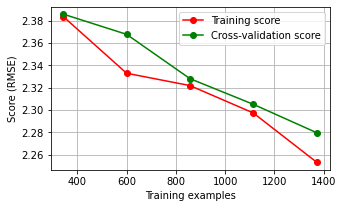

In [ ]:
knn = KNeighborsClassifier(n_neighbors=200)
train_sizes = np.linspace(0.2, 0.8, 5)


train_sizes, train_mse, test_mse = learning_curve(knn, X_test, y_test, 
                                    train_sizes = train_sizes, 
                                    scoring='neg_root_mean_squared_error', 
                                    cv=3, shuffle=True)

train_scores = np.sqrt(np.abs(train_mse))
test_scores = np.sqrt(np.abs(test_mse))

print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    

ax.set_xlabel("Training examples")
ax.set_ylabel("Score (RMSE)")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.show()

[[1.33699292 1.62044486 1.48477405]
 [1.3476392  1.43693566 1.51020405]
 [1.34886855 1.40850658 1.39698689]
 [1.42020546 1.44396717 1.48688772]
 [1.40015435 1.4266748  1.36842283]]
[[2.00965452 1.96068575 1.98019943]
 [1.92156944 1.93542248 1.88391132]
 [1.91612561 1.89984952 1.87450444]
 [1.91975997 1.85753827 1.84279486]
 [1.89159516 1.82978209 1.82654555]]


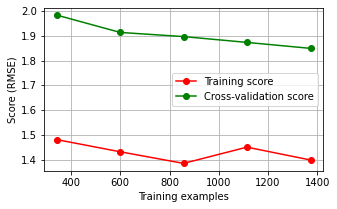

In [ ]:
svc = SVC(kernel='rbf')
train_sizes = np.linspace(0.2, 0.8, 5)


train_sizes, train_mse, test_mse = learning_curve(svc, X_test, y_test, 
                                    train_sizes = train_sizes, 
                                    scoring='neg_root_mean_squared_error', 
                                    cv=3, shuffle=True)

train_scores = np.sqrt(np.abs(train_mse))
test_scores = np.sqrt(np.abs(test_mse))

print(train_scores)
print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    

ax.set_xlabel("Training examples")
ax.set_ylabel("Score (RMSE)")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.show()